In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt

In [2]:
def normaliza_df(df, onehotencoder = None):
    print(df.shape)

    # drops -------------------------------------------------
    '''
      removemos la columna de la cual el modelo podria aprender que su existencia
      implica el Closed_won (ya que es un valor que se obtiene a posteriori de haber
      ganado y estaria mal usarlo ya que los modelos entrenadas con ella serian 
      incapaces de poder predecir correctamente)
    '''
    df = df.drop(['Sales_Contract_No'], axis=1)
    
    # irrelevantes (se eliminan) ----------------------------------------------
    
    # Total_Taxable_Amount = Sum rows[Total_Amount]
    
    # preparamos la columna Total_Taxable_Amount para ser aplanada
    df["Total_Amount_sum"] = df.groupby("Opportunity_ID")["Total_Amount"].transform("sum")

    df = df.drop(['Total_Taxable_Amount'], axis=1)
    df = df.drop(['Total_Amount_Currency'], axis=1)

    
    # esta columna es equivalente a oportunity_id
    df = df.drop(['Opportunity_Name'], axis=1)
    
    # dato cte = NaT
    df = df.drop(['Last_Activity'], axis=1)
    
    # todo: convertir estas en una ventana de tiempo
    df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], format="%m/%d/%Y")
    df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'], format="%m/%d/%Y")
    
    df['Planned_Delivery_Date_diff'] = (df['Planned_Delivery_End_Date'] - df['Planned_Delivery_Start_Date']).dt.days
    
    df = df.drop(['Planned_Delivery_Start_Date'], axis=1)
    df = df.drop(['Planned_Delivery_End_Date'], axis=1)
    
    # @todo: no estoy seguro si esto aporta
    df = df.drop(['Quote_Expiry_Date'], axis=1)
    
    # @todo: convertirla a una diferencia de dias?
    df = df.drop(['Last_Modified_Date'], axis=1)
    
    # @todo: existe Opportunity_id 
    df = df.drop(['ID'], axis=1)

    # basado en lo charlado con el grupo, ahora subdividimos el df de forma de tener
    # en cuenta los casos cerrados y cobertimos las varaibles categorias en su
    # representacion mas simple (siendo dos casos en Cloased_Won = 1 y Closed:_lost = 0)
    if 'Stage' in df.columns:
        df = df[((df['Stage'] == 'Closed Won') | (df['Stage'] == 'Closed Lost'))]
        df['Stage'] = df['Stage'].apply(lambda x: 1 if x == 'Closed Won' else 0)
    
    # hacemos que las variables temporales en las que nos vanos a enfocar sean del tipo correcto
    df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], format="%m/%d/%Y")
    df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'], format="%m/%d/%Y")
    
    df['Quote_Type'] = df['Quote_Type'].apply(lambda x: 1 if x == 'Binding' else 0)
    
    #------------------------------------------
    df = df.sort_values(by="Opportunity_Created_Date")
    
    df = df.drop(columns = 'Opportunity_Created_Date')
    df = df.drop(columns = 'Account_Created_Date')
    #------------------------------------------
    
    categoric_cols = df.columns[df.dtypes==object].tolist() 
    numeric_cols = df.columns[df.dtypes=='float64'].tolist() 
    numeric_cols_2 = df.columns[df.dtypes=='int64'].tolist() 
    date_cols = df.columns[df.dtypes=='datetime64[ns]'].tolist() 

    if 'Stage' in df.columns:
        onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
        onehotencoder.fit(df[categoric_cols])
    
    cat_rel = 0
    all_col_names = []
    for cat in onehotencoder.categories_:
        for col in cat:
            all_col_names.append(categoric_cols[cat_rel] + '_' + col)
        cat_rel = cat_rel + 1
    
    categorical = pd.DataFrame(onehotencoder.transform(df[categoric_cols]).toarray(), columns=all_col_names)
    
    categorical = categorical.reset_index()
    df = df.reset_index()
    
    frames_to_concat = [categorical, df[numeric_cols], df[numeric_cols_2]]
    df_r =  pd.concat(frames_to_concat, axis=1)
       
    df_r = df_r.drop(columns = 'index')
    
    return df_r, onehotencoder

In [3]:
test = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Test_TP2_Datos_2020-2C.csv')

train = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Train_TP2_Datos_2020-2C.csv')

In [4]:
[trainOneHot, onehotencoder] = normaliza_df(train)
[testOneHot,_ ] = normaliza_df(test,onehotencoder)

(16947, 52)
(2551, 51)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(trainOneHot.drop(columns = 'Stage'), trainOneHot['Stage'], test_size=0.2, random_state=123)


In [ ]:
xg_reg = xgb.XGBRegressor(
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 25, n_estimators = 100)


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

xg_reg.score(X_test,X_test)

In [ ]:
xg_reg = xgb.XGBRegressor(max_depth = 5,min_child_weight = 1,gamma = 0,subsample = 0.8
                          , colsample_bytree = 0.8,scale_pos_weight = 1 )


xg_reg.fit(X_train,y_train)



preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
xg_reg.score(X_test,X_test)

In [8]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["Stage"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Stage'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Stage'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Stage'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.head(10).plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [9]:
predictors = [x for x in trainOneHot.columns if x not in ["Stage"]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy : 0.9855
AUC Score (Train): 0.998969


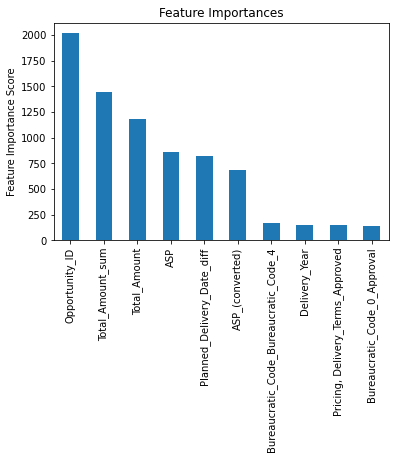

In [10]:
modelfit(xgb1, trainOneHot, predictors)

# Tune max_depth and min_child_weight

In [11]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(trainOneHot[predictors],trainOneHot["Stage"])

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [13]:

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 61.01616249,  62.03416166,  61.73850632,  95.30421834,
          95.09405322,  95.69119635, 129.81066542, 130.93719077,
         130.88903308, 166.37948203, 166.95444498, 151.51132784]),
  'std_fit_time': array([ 0.28779644,  0.52241626,  0.60717928,  0.83731072,  0.65041585,
          0.51168333,  1.06840992,  0.93270113,  0.97634587,  0.91573166,
          0.67611523, 17.91839146]),
  'mean_score_time': array([0.53149018, 0.43694448, 0.51206617, 0.60708694, 0.59519439,
         0.56202936, 0.64463558, 0.60324669, 0.63892274, 0.58289394,
         0.68786716, 0.52933016]),
  'std_score_time': array([0.11676947, 0.08899433, 0.13152541, 0.06960849, 0.09285908,
         0.09731032, 0.13815472, 0.07509786, 0.11339865, 0.11986144,
         0.08313589, 0.22372396]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [14]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([ 82.93035812,  83.55887079,  79.85332689,  95.5109271 ,
          94.82222686,  94.75396934, 112.49310637, 112.95645261,
          96.13107762]),
  'std_fit_time': array([ 0.79945037,  1.1526131 ,  2.29533143,  0.99077242,  0.27380576,
          0.73125553,  1.08704948,  0.94498888, 25.01897802]),
  'mean_score_time': array([0.5275929 , 0.54077358, 0.44695721, 0.55973396, 0.59043646,
         0.54923511, 0.56172018, 0.62574615, 0.44597783]),
  'std_score_time': array([0.07251595, 0.10473783, 0.05708084, 0.10305109, 0.07479511,
         0.10928174, 0.10664203, 0.08773789, 0.21879852]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
  

In [15]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(trainOneHot[predictors],trainOneHot["Stage"])

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [16]:
#modelfit(gsearch3.best_estimator_, trainOneHot, predictors)
#gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_


Model Report
Accuracy : 0.8837
AUC Score (Train): 0.955718


({'mean_fit_time': array([78.39437528, 78.08182154, 78.17174644, 77.59521117]),
  'std_fit_time': array([0.96873977, 0.56970917, 0.22475522, 0.61809204]),
  'mean_score_time': array([0.53881826, 0.47756872, 0.41007233, 0.40950842]),
  'std_score_time': array([0.17470324, 0.0473316 , 0.07086782, 0.11656306]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.50735047, 0.51013345, 0.49322635, 0.57373711]),
  'split1_test_score': array([0.35537315, 0.34842382, 0.33084679, 0.31914625]),
  'split2_test_score': array([0.54235042, 0.56313546, 0.55545573, 0.54190005]),
  'split3_test_score': array([0.76321802, 0.76209874, 0.77119408, 0.76781235]),
  'split4_test_score': array([0.9189707 , 0.92295026, 0.92365373, 0.91679034]),

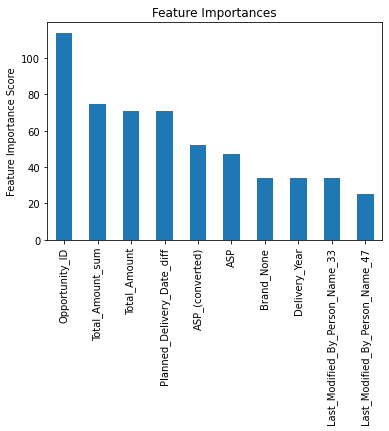

In [17]:
modelfit(gsearch2b.best_estimator_, trainOneHot, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [30]:
param_test1b = {
 'max_depth':range(10,60,10)},
 #'min_child_weight':range(1,6,2)}
gsearch1b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1b.fit(trainOneHot[predictors],trainOneHot["Stage"])

gsearch1b.cv_results_, gsearch1b.best_params_, gsearch1b.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([242.99461837, 471.25145345, 555.83429255, 599.61673141,
         553.49291501]),
  'std_fit_time': array([ 5.61761972,  9.24890979, 19.13707336, 23.57333309, 74.39662519]),
  'mean_score_time': array([0.77977476, 1.32571144, 0.88542213, 1.34325747, 0.75541248]),
  'std_score_time': array([0.18755004, 0.23169766, 0.25298499, 0.3374963 , 0.38993839]),
  'param_max_depth': masked_array(data=[10, 20, 30, 40, 50],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 10},
   {'max_depth': 20},
   {'max_depth': 30},
   {'max_depth': 40},
   {'max_depth': 50}],
  'split0_test_score': array([0.47843445, 0.49887917, 0.49062619, 0.47944076, 0.47702218]),
  'split1_test_score': array([0.28501065, 0.29251219, 0.29125884, 0.29259085, 0.29024414]),
  'split2_test_score': array([0.52171948, 0.51122039, 0.51297315, 0.51241613, 0.51470451]),
  'split3_test_score': array([0.75226513, 0.75633213,

# Tune gamma

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([78.58070192, 77.97474976, 78.50783935, 78.51384668, 67.56039505]),
  'std_fit_time': array([ 0.37422746,  0.38121044,  0.48132609,  0.47528104, 20.30124489]),
  'mean_score_time': array([0.53466086, 0.49570746, 0.50268154, 0.47620692, 0.38758183]),
  'std_score_time': array([0.09441813, 0.07801381, 0.16460609, 0.07994853, 0.09391039]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.50735047, 0.48439334, 0.52005536, 0.51939435, 0.47116388]),
  'split1_test_score': array([0.35537315, 0.34859255, 0.34869332, 0.3553876 , 0.35568297]),
  'split2_test_score': array([0.54235042, 0.54231885, 0.54212301, 0.55423502, 0.57252585]),
  'split3_test_score': array([0.76321802, 0.76920252, 0.75912746, 0.76791907, 0.7


Model Report
Accuracy : 0.9591
AUC Score (Train): 0.993127


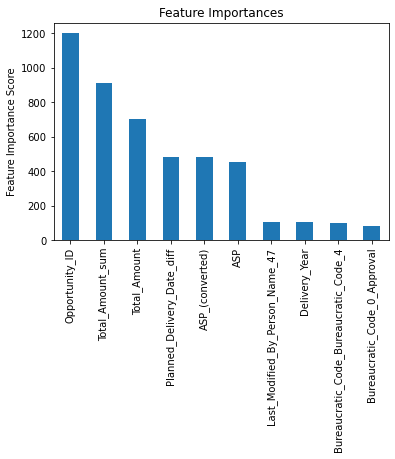

In [19]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, trainOneHot, predictors)

# Tune subsample and colsample_bytree

In [20]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([ 86.75348182,  83.42237535,  78.72070041,  75.10979948,
          96.68029261,  92.99086556,  88.35478268,  84.96365876,
         107.87602639, 103.71084852,  98.70934105,  94.37020144,
         118.65402975, 114.5952704 , 107.80931325, 103.15802517]),
  'std_fit_time': array([1.20990431, 0.93942429, 1.89698552, 0.56006349, 1.49843173,
         1.10493194, 0.84329283, 1.04267487, 1.1421291 , 0.35350141,
         1.23292718, 0.42825043, 0.79717982, 0.65320714, 0.53266375,
         0.58118395]),
  'mean_score_time': array([0.49532394, 0.54505615, 0.56165977, 0.57016931, 0.55440302,
         0.53535218, 0.5526823 , 0.52796082, 0.58243351, 0.65018635,
         0.50567651, 0.48320017, 0.49585972, 0.53314157, 0.59164777,
         0.43383303]),
  'std_score_time': array([0.11703394, 0.10310169, 0.09384282, 0.04853249, 0.08405161,
         0.10556908, 0.09161194, 0.1258818 , 0.07467773, 0.10401368,
         0.08972052, 0.10132661, 0.14178033, 0.15010637, 0.06366848,
 

In [21]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(trainOneHot[predictors],trainOneHot["Stage"])

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

# Tuning Regularization Parameters

In [22]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([98.7369535 , 97.9632473 , 98.4220531 , 98.32800846, 58.84017138]),
  'std_fit_time': array([ 0.53868568,  0.56926102,  0.44431853,  0.20561013, 18.2183851 ]),
  'mean_score_time': array([0.52409577, 0.47407489, 0.42859335, 0.43409705, 0.44166622]),
  'std_score_time': array([0.12296092, 0.0902389 , 0.082107  , 0.08786557, 0.15204712]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.47083837, 0.51942521, 0.49219292, 0.48752163, 0.49486782]),
  'split1_test_score': array([0.31351555, 0.31158656, 0.30682555, 0.30116345, 0.68843769]),
  'split2_test_score': array([0.49656796, 0.49486478, 0.51757417, 0.48986405, 0.74100967]),
  'split3_test_score': array([0.75423261, 0.74529931, 0

In [29]:
param_test6b = {
 'reg_alpha':[110, 120, 130,140,150]
}
gsearch6b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6b.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch6b.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([ 89.97248616,  99.41490245, 106.5416923 ,  84.95680189,
          66.40272722]),
  'std_fit_time': array([ 3.22023721,  5.82062219,  6.39334509,  8.22601987, 22.15601155]),
  'mean_score_time': array([0.87404852, 1.02235885, 0.98667693, 0.64468799, 0.46712222]),
  'std_score_time': array([0.33818281, 0.31057104, 0.36888173, 0.17191986, 0.16513723]),
  'param_reg_alpha': masked_array(data=[110, 120, 130, 140, 150],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 110},
   {'reg_alpha': 120},
   {'reg_alpha': 130},
   {'reg_alpha': 140},
   {'reg_alpha': 150}],
  'split0_test_score': array([0.4736226 , 0.48668154, 0.50895216, 0.5289879 , 0.54788053]),
  'split1_test_score': array([0.71903353, 0.73172362, 0.7445951 , 0.75565371, 0.77302313]),
  'split2_test_score': array([0.77777415, 0.78262613, 0.80002051, 0.80807605, 0.80537922]),
  'split3_test_score': array([0.81311986, 0

In [25]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(trainOneHot[predictors],trainOneHot["Stage"])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'mean_fit_time': array([104.75198464, 100.89393978,  98.02232018,  97.58725996,
          84.79944077]),
  'std_fit_time': array([ 1.46961787,  2.66427137,  0.12449177,  0.22030372, 25.9799726 ]),
  'mean_score_time': array([0.52996426, 0.49929504, 0.56409249, 0.49583216, 0.50858665]),
  'std_score_time': array([0.10387917, 0.07056488, 0.14254433, 0.08689554, 0.16212271]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.47083837, 0.52115835, 0.49080687, 0.51942521, 0.4719353 ]),
  'split1_test_score': array([0.31351555, 0.31351519, 0.31885713, 0.31158656, 0.29652391]),
  'split2_test_score': array([0.49656796, 0.49657759, 0.49803392, 0.49486478, 0.48946238]),
  'split3_test_score': array([0.754


Model Report
Accuracy : 0.9601
AUC Score (Train): 0.993168


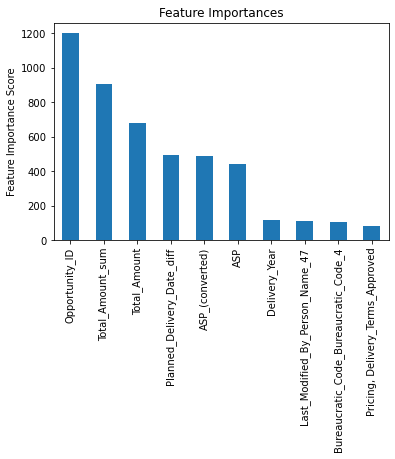

In [26]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, trainOneHot, predictors)

# Reducing Learning Rate


Model Report
Accuracy : 0.9289
AUC Score (Train): 0.982271


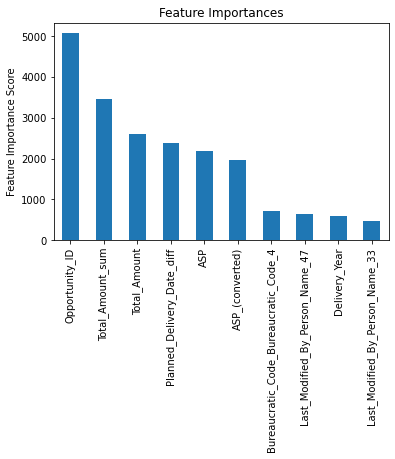

In [27]:
xgb4 = XGBClassifier(grid_scores_
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, trainOneHot, predictors)